### **Deep Learning Project**  
Emotions Detection Through Transfer Learning Using VGG-Face Model

In [3]:
!pip install keras-vggface


[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [63]:
%matplotlib inline

In [1]:
import tensorflow as tf
#from keras.applications import VGGFace
from keras_vggface.vggface import VGGFace

In [2]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
import cv2
from sklearn.model_selection import train_test_split

In [3]:
def LoadData(csv_path, img_dir):
    df = pd.read_csv(csv_path)
    X=[]
    y=[]
    #emotions_label = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    
    for _, row in df.iterrows():
        img_path = os.path.join(img_dir, row['pth'])
        
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (96, 96))
                X.append(img)

                # Convert emotion label to numeric label
                emotion_label = row['label']
                if emotion_label == 'anger':
                    numeric_label = 0
                elif emotion_label == 'contempt':
                    numeric_label = 1
                elif emotion_label == 'disgust':
                    numeric_label = 2
                elif emotion_label == 'fear':
                    numeric_label = 3
                elif emotion_label == 'happy':
                    numeric_label = 4
                elif emotion_label == 'neutral':
                    numeric_label = 5
                elif emotion_label == 'sad':
                    numeric_label = 6
                elif emotion_label == 'surprise':
                    numeric_label = 7
                else:
                    raise ValueError(f"Unknown emotion label: {emotion_label}")
                
                y.append(numeric_label)
            else:
                print(f"Image is not found or cannot be read: {img_path}")
        else:
            print(f"Image path does not exist: {img_path}")
    
    return np.array(X), to_categorical(np.array(y), num_classes=len(df['label'].unique()))

In [4]:
csv_path = 'C:/Users/Dell/Documents/DLFinalProject_Data/labels.csv'
img_dir = 'C:/Users/Dell/Documents/DLFinalProject_Data'

In [5]:
X, y = LoadData(csv_path, img_dir)

In [6]:
print("X:", X.shape)
print("y: ", y.shape)

X: (28175, 96, 96, 3)
y:  (28175, 8)


There are 28,175 images in the whole dataset, with size 96x96 (the input size of VGGFace model is usually 244x244 but if I kept it at the original size, I don't have enough memory and can't normalize the data) and eight different classes or emotions

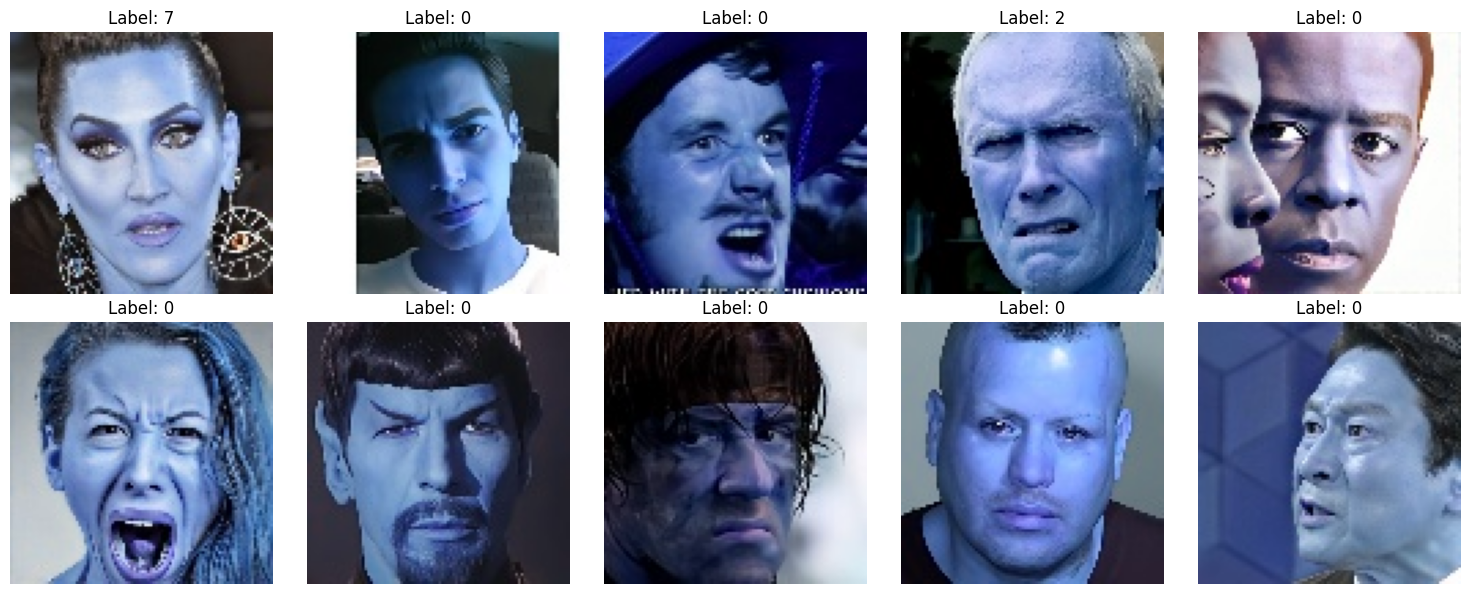

In [6]:
import matplotlib.pyplot as plt

# Plot some images with labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(X[i])
    ax.set_title(f"Label: {np.argmax(y[i])}")  # Assuming y is one-hot encoded
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1, l2

In [8]:
baseModel = VGGFace(include_top=False, input_shape=(96, 96, 3))

In [9]:
X.shape

(28175, 96, 96, 3)

In [10]:
#Custom Layers

x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu', kernel_regularizer=l2(0.01))(x)
x = Dense(512, activation = 'relu')(x)
output = Dense(8, activation = 'softmax')(x)

In [11]:
#Freezing VGGFace layers

for layer in baseModel.layers:
    layer.trainable = False

In [12]:
customModel = Model(inputs=baseModel.input, outputs=output) #!! USE THIS!!
customModel.compile(optimizer = Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [13]:
customModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 96, 96, 64)        1792      
                                                                 
 conv1_2 (Conv2D)            (None, 96, 96, 64)        36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 48, 48, 64)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 48, 48, 128)       73856     
                                                                 
 conv2_2 (Conv2D)            (None, 48, 48, 128)       147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 24, 24, 128)       0     

In [89]:
pip install visualkeras

     ---------------------------------------- 0.0/45.0 kB ? eta -:--:--
     ----------------- -------------------- 20.5/45.0 kB 682.7 kB/s eta 0:00:01
     ---------------------------------- --- 41.0/45.0 kB 653.6 kB/s eta 0:00:01
     -------------------------------------- 45.0/45.0 kB 445.1 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


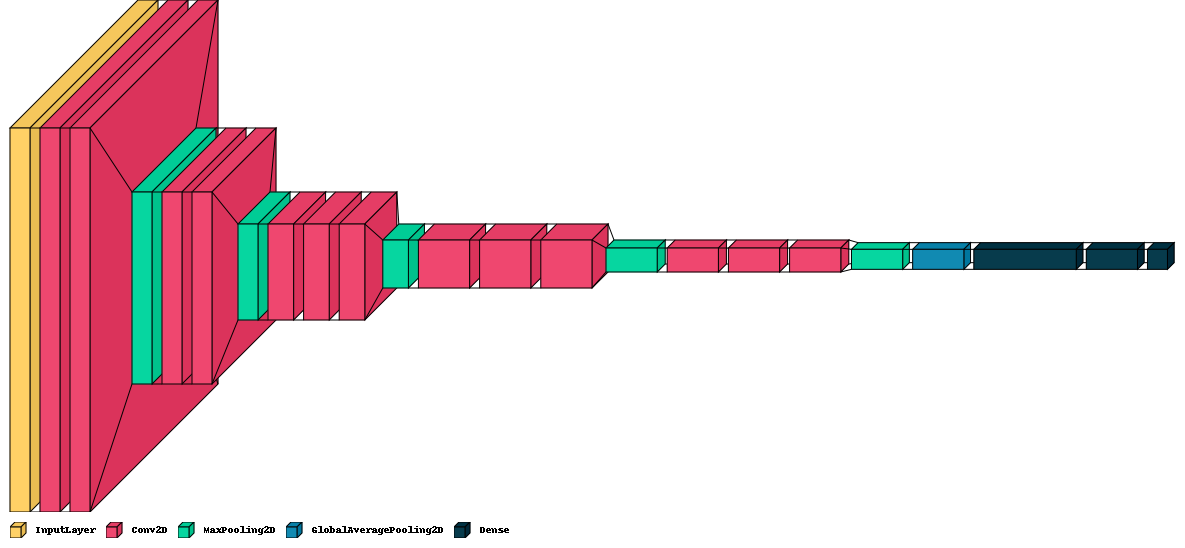

In [90]:
import visualkeras
visualkeras.layered_view(customModel, legend=True)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
mean = np.mean(X_train)
std = np.std(X_train)

X_train_normalized = (X_train - mean) / std
X_test_normalized = (X_test - mean) / std

In [18]:
X_train = X_train_normalized
X_test = X_test_normalized

In [19]:
historyCustom = customModel.fit(
    X_train,
    y_train,
    validation_data = (X_test, y_test),
    epochs = 10,
    batch_size = 128
)

Epoch 1/10
177/177 [==============================] - 1221s 7s/step - loss: 6.6660 - accuracy: 0.2566 - val_loss: 4.9004 - val_accuracy: 0.3022
Epoch 2/10
177/177 [==============================] - 1217s 7s/step - loss: 3.9092 - accuracy: 0.3313 - val_loss: 3.1563 - val_accuracy: 0.3377
Epoch 3/10
177/177 [==============================] - 1190s 7s/step - loss: 2.7208 - accuracy: 0.3581 - val_loss: 2.4167 - val_accuracy: 0.3491
Epoch 4/10
177/177 [==============================] - 1610s 9s/step - loss: 2.2065 - accuracy: 0.3750 - val_loss: 2.0984 - val_accuracy: 0.3500
Epoch 5/10
177/177 [==============================] - 1168s 7s/step - loss: 1.9713 - accuracy: 0.3868 - val_loss: 1.9346 - val_accuracy: 0.3617
Epoch 6/10
177/177 [==============================] - 1122s 6s/step - loss: 1.8581 - accuracy: 0.3894 - val_loss: 1.8605 - val_accuracy: 0.3697
Epoch 7/10
177/177 [==============================] - 1107s 6s/step - loss: 1.7937 - accuracy: 0.3967 - val_loss: 1.8177 - val_accuracy:

In [21]:
customModel.save('vggF.h5')

In [24]:
# Unfreeze some layers for fine-tuning
for layer in customModel.layers[-4:]:
    layer.trainable = True

In [25]:
customModel.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
historyUnfrozen = customModel.fit(
    X_train,
    y_train,
    validation_data = (X_test, y_test),
    epochs = 10,
    batch_size = 128
)

Epoch 1/10
177/177 [==============================] - 909s 5s/step - loss: 1.6825 - accuracy: 0.4198 - val_loss: 1.7387 - val_accuracy: 0.3856
Epoch 2/10
177/177 [==============================] - 1100s 6s/step - loss: 1.6698 - accuracy: 0.4213 - val_loss: 1.7276 - val_accuracy: 0.3824
Epoch 3/10
177/177 [==============================] - 1087s 6s/step - loss: 1.6565 - accuracy: 0.4256 - val_loss: 1.7082 - val_accuracy: 0.3933
Epoch 4/10
177/177 [==============================] - 1103s 6s/step - loss: 1.6433 - accuracy: 0.4310 - val_loss: 1.7016 - val_accuracy: 0.3963
Epoch 5/10
177/177 [==============================] - 1088s 6s/step - loss: 1.6340 - accuracy: 0.4322 - val_loss: 1.7194 - val_accuracy: 0.3966
Epoch 6/10
177/177 [==============================] - 1101s 6s/step - loss: 1.6262 - accuracy: 0.4341 - val_loss: 1.7002 - val_accuracy: 0.3965
Epoch 7/10
177/177 [==============================] - 1107s 6s/step - loss: 1.6131 - accuracy: 0.4409 - val_loss: 1.7016 - val_accuracy: 

In [27]:
customModel.save('vggU.h5')

In [32]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

**TRIAL**

In [70]:
# Prediction function
def predict_emotion(customModel, image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be read.")
    
    img_resized = cv2.resize(img, (96, 96))
    img_normalized = img_resized.astype('float32') / 255.0  # Normalize the image
    img_expanded = np.expand_dims(img_normalized, axis=0)  # Add batch dimension
    
    prediction = customModel.predict(img_expanded)
    emotion_labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    predicted_emotion = emotion_labels[np.argmax(prediction)]
    
    # Display the image with predicted emotion
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted Emotion: {predicted_emotion}")
    plt.axis('off')
    plt.show()
    
    return predicted_emotion

1/1 [==============================] - 0s 43ms/step


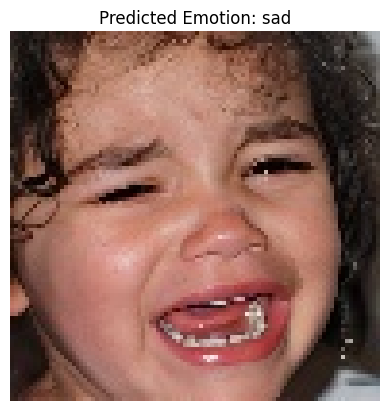

Predicted emotion: sad


In [71]:
# Example usage
predicted_emotion2 = predict_emotion(customModel, 'C:/Users/Dell/Documents/DLFinalProject_Data/Predict1.jpg')
print(f"Predicted emotion: {predicted_emotion2}")

1/1 [==============================] - 0s 47ms/step


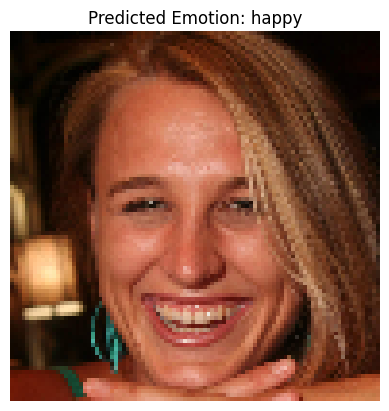

Predicted emotion: happy


In [80]:
# Example usage
predicted_emotion1 = predict_emotion(customModel, 'C:/Users/Dell/Documents/DLFinalProject_Data/Predict2.png')
print(f"Predicted emotion: {predicted_emotion1}")

1/1 [==============================] - 0s 67ms/step


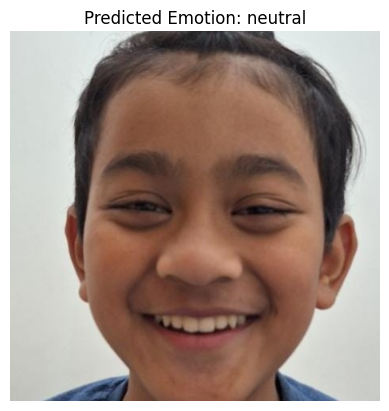

Predicted emotion: neutral


In [103]:
# Example usage
predicted_emotionOri1 = predict_emotion(customModel, 'C:/Users/Dell/Documents/DLFinalProject_Data/PredictOri.jpg')
print(f"Predicted emotion: {predicted_emotionOri1}")

Supposed to be happy but is detected as neutral

1/1 [==============================] - 0s 43ms/step


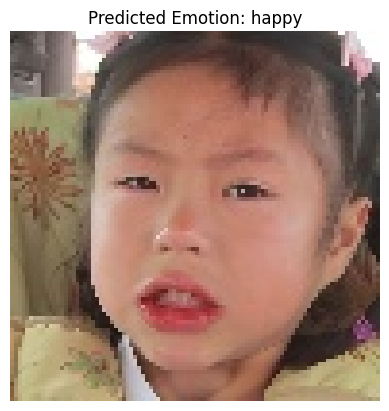

Predicted emotion: happy


In [85]:
# Example usage
predicted_emotion3 = predict_emotion(customModel, 'C:/Users/Dell/Documents/DLFinalProject_Data/Predict3.jpg')
print(f"Predicted emotion: {predicted_emotion3}")

Supposed to be angry/sad but detected as happy

1/1 [==============================] - 0s 64ms/step


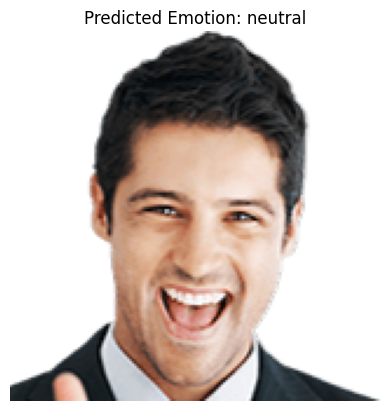

Predicted emotion: neutral


In [97]:
# Example usage
predicted_Google = predict_emotion(customModel, 'C:/Users/Dell/Documents/DLFinalProject_Data/PredictTrial.png')
print(f"Predicted emotion: {predicted_Google}")

Supposed to be happy but detected as neutral

1/1 [==============================] - 0s 65ms/step


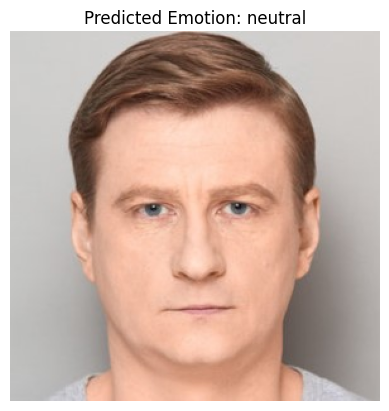

Predicted emotion: neutral


In [99]:
# Example usage
predicted_Google2 = predict_emotion(customModel, 'C:/Users/Dell/Documents/DLFinalProject_Data/PredictTrial2.jpg')
print(f"Predicted emotion: {predicted_Google2}")

1/1 [==============================] - 0s 68ms/step


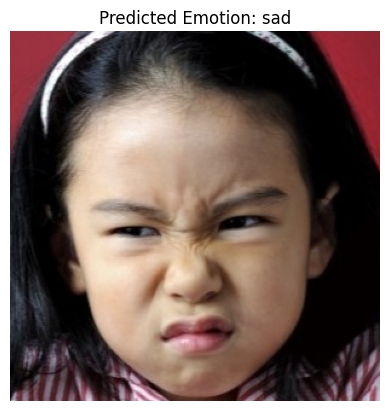

Predicted emotion: sad
1/1 [==============================] - 0s 65ms/step


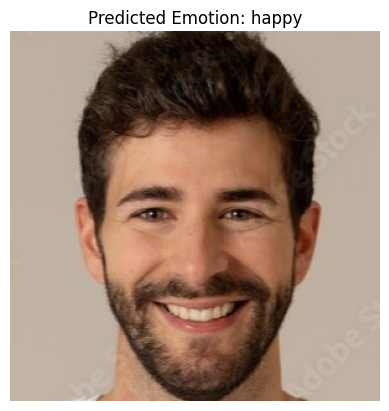

Predicted emotion: happy


In [101]:
# Example usage
predictedAngry = predict_emotion(customModel, 'C:/Users/Dell/Documents/DLFinalProject_Data/DemoA.jpg')
print(f"Predicted emotion: {predictedAngry}")

# Example usage
predictedHappy = predict_emotion(customModel, 'C:/Users/Dell/Documents/DLFinalProject_Data/DemoB.jpg')
print(f"Predicted emotion: {predictedHappy}")

1st pic: can be sad, can be angry

1/1 [==============================] - 0s 51ms/step


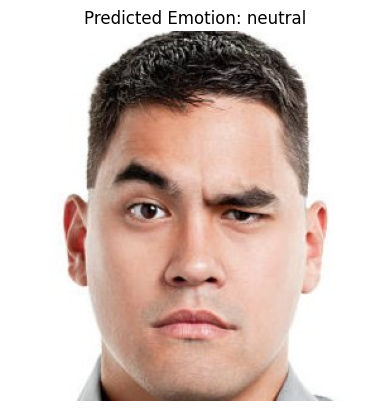

Predicted emotion: neutral
1/1 [==============================] - 0s 47ms/step


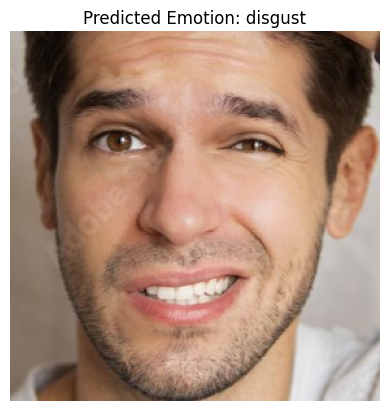

Predicted emotion: disgust


In [105]:
# Example usage
predictedAngry = predict_emotion(customModel, 'C:/Users/Dell/Documents/DLFinalProject_Data/TrialConfused.jpg')
print(f"Predicted emotion: {predictedAngry}")

# Example usage
predictedHappy = predict_emotion(customModel, 'C:/Users/Dell/Documents/DLFinalProject_Data/TrialConfused2.jpg')
print(f"Predicted emotion: {predictedHappy}")

In [67]:
img = cv2.imread('C:/Users/Dell/Documents/DLFinalProject_Data/Predict1.jpg')
print(f"Image shape: {img.shape}")  # Check if image is loaded correctly

Image shape: (96, 96, 3)


In [35]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up the test generator
test_generator = test_datagen.flow_from_directory(
    'C:/Users/Dell/Documents/DLFinalProject_Data',
    target_size=(96, 96),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

Found 29042 images belonging to 8 classes.


In [30]:
from tensorflow.keras.models import load_model

vggF_metric = load_model('vggF.h5')
vggU_metric = load_model('vggU.h5')

In [ ]:
vggF_eval = vggF_metric.evaluate(test_generator)
vggU_eval = vggU_metric.evaluate(test_generator)

In [ ]:
#Plot metrics for Frozen & Unfrozen Models 

def plot_metrics(history1, history2, metric):
    plt.figure(figsize=(12, 5))
    
    # Plot for vggF model
    plt.subplot(1, 2, 1)
    plt.plot(history1.history[metric], label='Train')
    plt.plot(history1.history[f'val_{metric}'], label='Validation')
    plt.title(f'VGG-Face: {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    
    # Plot for vggU model
    plt.subplot(1, 2, 2)
    plt.plot(history2.history[metric], label='Train')
    plt.plot(history2.history[f'val_{metric}'], label='Validation')
    plt.title(f'VGG-Unfrozen: {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Assuming you have the history objects saved
vggF_history = vggF_metric.history
vggU_history = vggU_metric.history

# Plot accuracy
plot_metrics(vggF_history, vggU_history, 'accuracy')

# Plot loss
plot_metrics(vggF_history, vggU_history, 'loss')